Code cleaup. Need to 
1. remove repeated sentences due to vtt formatting
2. some words are concatenated together (helloBut--> hello But, swimming in a pool.We--> swimming in a pool. We)

In [2]:
import glob
import json
import regex as re
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus.reader import *
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiwonlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiwonlee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
with open('../channelHolisticInfo.json', 'r') as j:
    channelHolisticInfo = json.loads(j.read())
channelHolisticInfoDf = pd.DataFrame.from_dict(channelHolisticInfo)
channelHolisticInfoDf.head()

,channelName,channelId,daysLiveAsOfLaunch,daysSinceFirstVideo,description,viewCount,subscriberCount,videoCount,firstUploadDate,subscribersPerYearSinceFirstUpload,viewCountPerYearSinceFirstUpload
0,Alex Clark,UCsDmESjqNPukDmVnuneLrqw,4392,4389,Funny vids about my life. I'm thankful for th...,471903125,4280000,317,2009-12-07T21:13:28Z,355935.292777,3.924462e+07
1,Alex Meyers,UCY6Ij8zOds0WJEeqCLOnqOQ,2348,2341,I make cartoons and sometimes video essays abo...,472627239,2870000,256,2015-07-18T11:43:37Z,447479.709526,7.369028e+07
2,WowRightMeow,UClN24S5-fc7LD0JJW0FdGWw,1946,1809,"Yo! I'm Jamie, a dorky human from Wales. Did a...",29732357,537000,33,2016-12-31T15:08:07Z,108349.917081,5.999066e+06
3,Andrei Terbea,UC3iNdSV_RQU7DHTGpqEW96w,3147,3149,Doing animated commentary and solving crimes w...,292193694,2860000,136,2013-04-30T20:01:32Z,331502.064147,3.386812e+07
4,Billy But Better,UC_52i6mlrzOZs_NEuSepzAg,2805,1736,"Yes, it's a foot.\n\nSocial Medias:\nTwitter -...",12166120,260000,23,2017-03-14T02:31:14Z,54665.898618,2.557969e+06


In [4]:
LIST_OF_CHANNEL_IDS = channelHolisticInfoDf['channelId'].tolist()
LIST_OF_CHANNEL_NAMES = channelHolisticInfoDf['channelName'].tolist()
LIST_OF_VIDEO_COUNT = channelHolisticInfoDf['videoCount'].tolist()

In [6]:
def generateListOfSentences(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        strippedLines = [line.strip() for line in lines if line.strip()] 
        removeDuplicatedLinesList = []
        for index in range(len(strippedLines)-1):
            removeDuplicatedLinesList.append(strippedLines[index])
    return list(set(removeDuplicatedLinesList))

# print(generateListOfSentences("UCAlxwHEm1bWWYoe5VCSQYEg/txt/_9KytbCHaXU.txt"))

def generateListOfWords(listOfSentences):
    all_stopwords = list(stopwords.words('english'))
    cleanedListOfWords = []
    for words in listOfSentences:
        word = re.split('[?."(),!) ]', words)
        for wo in word:
            if wo !='' and wo not in all_stopwords:
                cleanedListOfWords.append(wo)
    return cleanedListOfWords

def flattenList(list):
    flat_list = [item for sublist in list for item in sublist]
    return flat_list

#wordCloud[channelId] = all words from all .txt files with no stopwords
#sentenceCloud[channelId] = all sentences from all .txt files.

wordCloud = {}
sentenceCloud = {}
for channelId in LIST_OF_CHANNEL_IDS:
    listOfSentences = []
    listOfWords = []
    print(channelId, "has ", len(glob.glob(channelId+"/txt/*.txt")), "files to process.")
    for txtFilePath in glob.glob(channelId+"/txt/*.txt"):
        listOfSentences.append(generateListOfSentences(txtFilePath))
    flattenedListOfSentences = flattenList(listOfSentences) #<--
    flattendListOfWords = generateListOfWords(flattenedListOfSentences)

    sentenceCloud[channelId.split('/')[0]] = flattenedListOfSentences
    wordCloud[channelId.split('/')[0]] = flattendListOfWords
    print(channelId.split('/')[0], ": ", len(flattenedListOfSentences), "sentences total")
    print(channelId.split('/')[0], ": ", len(flattendListOfWords), "words total")

    # with open(channelId.split('/')[0]+"_wordCloud.txt", 'w') as f:
    #     json.dump(flattendListOfWords, f)
    # with open(channelId.split('/')[0]+"_sentenceCloud.txt", 'w') as f:
    #     json.dump(flattenedListOfSentences, f)

UCsDmESjqNPukDmVnuneLrqw has  298 files to process.
UCsDmESjqNPukDmVnuneLrqw :  35495 sentences total
UCsDmESjqNPukDmVnuneLrqw :  155629 words total
UCY6Ij8zOds0WJEeqCLOnqOQ has  250 files to process.
UCY6Ij8zOds0WJEeqCLOnqOQ :  81861 sentences total
UCY6Ij8zOds0WJEeqCLOnqOQ :  315581 words total
UClN24S5-fc7LD0JJW0FdGWw has  27 files to process.
UClN24S5-fc7LD0JJW0FdGWw :  5582 sentences total
UClN24S5-fc7LD0JJW0FdGWw :  20194 words total
UC3iNdSV_RQU7DHTGpqEW96w has  112 files to process.
UC3iNdSV_RQU7DHTGpqEW96w :  19042 sentences total
UC3iNdSV_RQU7DHTGpqEW96w :  76439 words total
UC_52i6mlrzOZs_NEuSepzAg has  23 files to process.
UC_52i6mlrzOZs_NEuSepzAg :  2594 sentences total
UC_52i6mlrzOZs_NEuSepzAg :  11450 words total
UCr3cBLTYmIK9kY0F_OdFWFQ has  80 files to process.
UCr3cBLTYmIK9kY0F_OdFWFQ :  9538 sentences total
UCr3cBLTYmIK9kY0F_OdFWFQ :  37907 words total
UCV6g95OBbVtFmN9uiJzkFqQ has  223 files to process.
UCV6g95OBbVtFmN9uiJzkFqQ :  11338 sentences total
UCV6g95OBbVtFm

Don't forget to find out how many caption files out of video published by channel

# Holistically

33


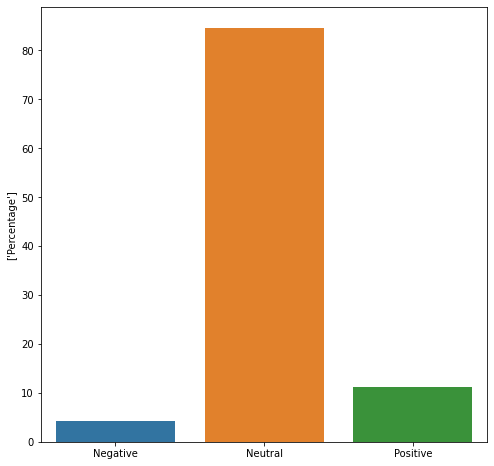

,neg,neu,pos,compound,words,label
0,0.0,1.0,0.0,0.0,Got,0
1,0.0,1.0,0.0,0.0,sunburned,0
2,0.0,1.0,0.0,0.0,dancing,0
3,0.0,1.0,0.0,0.0,waiting,0
4,0.0,1.0,0.0,0.0,evening,0


In [7]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []

print(len(wordCloud.keys()))
for channelId in LIST_OF_CHANNEL_IDS:
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

In [8]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,words,label
17,1.0,0.0,0.0,-0.1531,stops,-1
21,1.0,0.0,0.0,-0.1027,Nah,-1
22,1.0,0.0,0.0,-0.1027,nah,-1
23,1.0,0.0,0.0,-0.1027,nah,-1
24,1.0,0.0,0.0,-0.1027,nah,-1


In [9]:
print(df_positive_negative.label.value_counts())

 1    224624
-1     85038
Name: label, dtype: int64


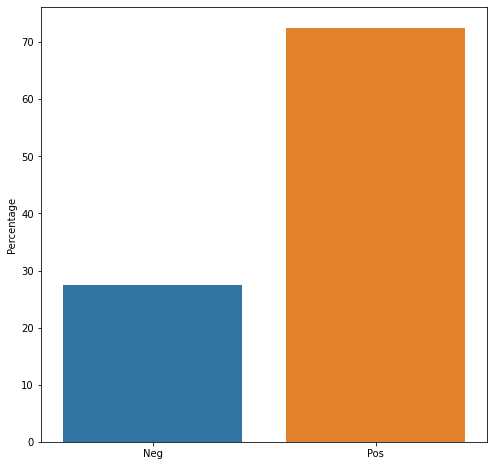

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

Basically, compared to redditors, animation youtubers are more 'positive'

# By Channel by words

In [28]:
channelId_to_df = {}
sia = SIA()
for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for words in wordCloud[channelId]:
        pol_score = sia.polarity_scores(words)
        pol_score['words']=words
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_df[channelId] = df
df[150:200]

,neg,neu,pos,compound,words
150,0.0,1.0,0.0,0.0000,maid
151,0.0,1.0,0.0,0.0000,Everything
152,0.0,0.0,0.0,0.0000,I
153,0.0,1.0,0.0,0.0000,touch
154,0.0,1.0,0.0,0.0000,turns
155,1.0,0.0,0.0,-0.4215,waste
156,0.0,1.0,0.0,0.0000,*Knock
157,0.0,1.0,0.0,0.0000,Knock
158,0.0,1.0,0.0,0.0000,Knock*
159,0.0,1.0,0.0,0.0000,Duh


In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generateWordCloud(pos_words_str, neg_words_str):
    wordcloud_positive = WordCloud(background_color='white').generate(pos_words_str)
    wordcloud_negative = WordCloud().generate(neg_words_str)

    plt.imshow(wordcloud_positive, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.imshow(wordcloud_negative, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [30]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_df[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].words)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].words)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
print(scores)

{'UCsDmESjqNPukDmVnuneLrqw': 0.03598800095098049, 'UCY6Ij8zOds0WJEeqCLOnqOQ': 0.03490942578925727, 'UClN24S5-fc7LD0JJW0FdGWw': 0.03125584827176393, 'UC3iNdSV_RQU7DHTGpqEW96w': 0.01964876306597452, 'UC_52i6mlrzOZs_NEuSepzAg': 0.026322620087336192, 'UCr3cBLTYmIK9kY0F_OdFWFQ': 0.022758392908961665, 'UCV6g95OBbVtFmN9uiJzkFqQ': 0.023039981595207707, 'UCgCKYs56-LKEPGQ99DzqQOg': 0.031858909310451676, 'UCOwxx9VnEnlFKt5EB70KTzQ': 0.020200437534182557, 'UC2Ds30pkifFVD0CE08wF50g': 0.02362694668117498, 'UC7UGbBVrqLlq6CRxWWUmyKw': 0.019298051268736693, 'UCn1XB-jvmd9fXMzhiA6IR0w': 0.030018270034608576, 'UCFeqAfEuKm7lIg2ddQzh61A': 0.03758699354558893, 'UCAlxwHEm1bWWYoe5VCSQYEg': 0.03718808725854707, 'UCz7iJPVTBGX6DNO1RNI2Fcg': 0.0069941702652683325, 'UCOAUz4d1NUNxSHh_SOJtdGQ': 0.0322028140226287, 'UCGGTAB19HlHEWPwwmxHsEKA': 0.029578237764072896, 'UCOsATJw-IZgqGT8MFrHjKGg': 0.0334704793028321, 'UCsKVP_4zQ877TEiH_Ih5yDQ': 0.02886641732407265, 'UCOinp9hALPUcZeoL3Kmaviw': 0.030129082855275432, 'UCGwu0nbY

# By sentences

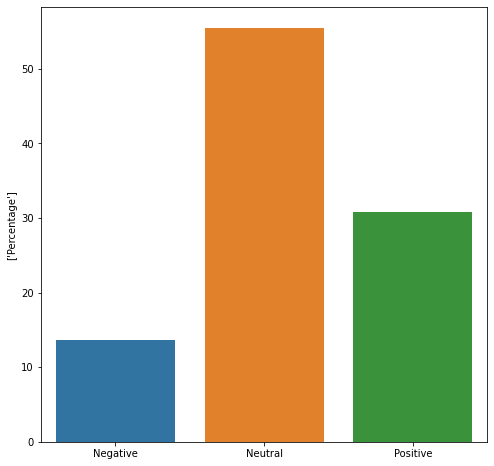

,neg,neu,pos,compound,sentence,label
0,0.535,0.465,0.0,-0.3182,I lost my suitcase,-1
1,0.000,1.000,0.0,0.0000,Twitter! Insta!,0
2,0.345,0.655,0.0,-0.4215,So when the carriage stops my new life will begin (Nah nah nah nah nah),-1
3,0.000,1.000,0.0,0.0000,(All you have to do all you have to do all you have to do all you have to do all you have to do),0
4,0.000,1.000,0.0,0.0000,"If you find this week's, Let me know in Twitter or Instagram.",0


In [43]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for channelId in LIST_OF_CHANNEL_IDS:
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1

import seaborn as sns
import matplotlib.pyplot as plt
fix, ax = plt.subplots(figsize=(8,8))
counts = df.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel(["Percentage"])
plt.show()

df.head()

# By channel by sentences

In [38]:
sentenceCloud[LIST_OF_CHANNEL_IDS[28]]

['Imagination, life is your creation!',
 'Think it\'s some kind of game to you? I\'LL SMACK YOU!"',
 'heaven? (take that, demonetization)',
 'Afro: "So why are you blaming me?!"',
 '2. He\'s colorblind as fuuucccckkkk."',
 'With our underdeveloped brains,',
 'Young Tabbes: "Wha-?"',
 'Reebok: "I think it was Afro."',
 '"N-',
 "Yeah I know that's a real beautiful way to start.",
 "play fighting which wasn't really play fighting and other feisty things.",
 'Reebok: "We\'re in a church."',
 "You think I'm spending all summer vacation in the same room as you?!?!",
 'Young Tabbes: "No, Reebok, that\'s not the situation right now!"',
 "-yeah, I know I'm old as fuck-",
 'This was "Afro", the oldest and toughest of the bunch',
 'This story takes place in a church basement. (Yikes)',
 'Well Afro, who was the oldest of our group told us;',
 '*damns and oohs*',
 'Maybe there\'s a key or something else in this room that can help us."',
 'Gal: "What? You think this is some kind of game, huh?',
 'Yo

In [11]:
#General sentiment by words spoken by youtubers

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
channelId_to_sentencedf = {}

for channelId in LIST_OF_CHANNEL_IDS:
    results = []
    for sentence in sentenceCloud[channelId]:
        pol_score = sia.polarity_scores(sentence)
        pol_score['sentence']=sentence
        results.append(pol_score)
    pd.set_option('display.max_columns', None, 'max_colwidth', None)
    df = pd.DataFrame.from_records(results)
    channelId_to_sentencedf[channelId] = df
df['label']=0
df.loc[df['compound'] > 0.10, 'label'] = 1
df.loc[df['compound'] < -0.10, 'label'] = -1


df.head()

,neg,neu,pos,compound,sentence,label
0,0.000,0.859,0.141,0.3182,That's a guaranteed 30 years in therapy when I bite down into a cold slice of fresh pizza.,1
1,0.000,0.732,0.268,0.2960,"Yeah, how does that make you feel?",1
2,0.000,1.000,0.000,0.0000,"Lemme just, turn that off..",0
3,0.447,0.553,0.000,-0.5667,"We can't play God, Michael. God is the meter maid.",-1
4,0.688,0.312,0.000,-0.2960,No I mean-,-1


In [12]:
df_positive_negative = df.loc[df['label'] != 0]
df_positive_negative.head()

,neg,neu,pos,compound,sentence,label
0,0.000,0.859,0.141,0.3182,That's a guaranteed 30 years in therapy when I bite down into a cold slice of fresh pizza.,1
1,0.000,0.732,0.268,0.2960,"Yeah, how does that make you feel?",1
3,0.447,0.553,0.000,-0.5667,"We can't play God, Michael. God is the meter maid.",-1
4,0.688,0.312,0.000,-0.2960,No I mean-,-1
6,0.306,0.694,0.000,-0.2960,"No, I'm not spinning the dial.",-1


In [13]:
print(df_positive_negative.label.value_counts())

 1    20
-1    10
Name: label, dtype: int64


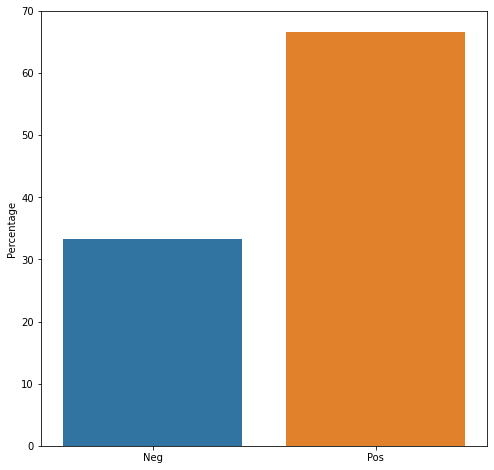

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
counts = df_positive_negative.label.value_counts(normalize=True)*100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Neg', 'Pos'])
ax.set_ylabel('Percentage')
plt.show()

In [15]:
top_20_pos_words = {}
top_20_neg_words = {}
scores= {}
for channelId in LIST_OF_CHANNEL_IDS:
    target_df = channelId_to_sentencedf[channelId]
    positive_words = list(target_df.loc[target_df['pos']==1].sentence)
    positive_frequency = FreqDist(positive_words)
    pos_freq = positive_frequency.most_common(20)
    negative_words = list(target_df.loc[target_df['neg']==1].sentence)
    negative_frequency = FreqDist(negative_words)
    neg_freq = negative_frequency.most_common(20)
    top_20_pos_words[channelId] = pos_freq
    top_20_neg_words[channelId] = neg_freq

    pos_words = [str(p) for p in pos_freq]
    pos_words_str = ', '.join(pos_words)
    neg_words = [str(n) for n in neg_freq]
    neg_words_str = ', '.join(neg_words)
    # generateWordCloud(pos_words_str, neg_words_str)

    scores[channelId] = sum(target_df['compound'])/len(target_df)
# print(scores)

channelName_to_scores = {}
for i in range(0, len(LIST_OF_CHANNEL_NAMES)):
    channelName_to_scores[LIST_OF_CHANNEL_NAMES[i]] = list(scores.values())[i]

avg_score=sum(channelName_to_scores.values())/len(LIST_OF_CHANNEL_NAMES)
print("avg score =", avg_score)
print(channelName_to_scores)
print(sorted(channelName_to_scores.items(), key=lambda item: item[1]))

avg score = 0.07597388354797362
{'Alex Clark': 0.12516857585575097, 'Alex Meyers': 0.10171017334262605, 'WowRightMeow': 0.08816854174131127, 'Andrei Terbea': 0.060722880999895736, 'Billy But Better': 0.08979263685427905, 'Casually Explained': 0.07362420842944016, 'CircleToonsHD': 0.0785860645616513, 'CurtRichy': 0.08384791048467052, 'CypherDen': 0.06808188185542464, 'Daidus': 0.06898366486850932, 'DanPlan': 0.054978589239966985, 'Domics': 0.10238580477972732, 'Emirichu': 0.11027874248445999, 'EroldStory': 0.11507509659290609, 'GradeAUnderA': 0.014606097560975603, 'GetMadz': 0.0916549109182281, 'GingerPale': 0.10900744269127716, 'Ice Cream Sandwich': 0.09104264705882338, 'illymation': 0.0758033845468716, 'Ivan Animated': 0.08914942616679404, 'Jaiden Animations': 0.08062958149207229, 'Let Me Explain Studios': 0.07389520283658356, 'Noodle': 0.06403156293222702, 'OverSimplified': -0.008489563758389367, 'TheOdd1sOut': 0.06449667373130859, 'PantslessPajamas': 0.07381724673710396, 'SomeThingE

In [16]:
sorted_channelName_to_scores = dict(sorted(channelName_to_scores.items(), key=lambda item: item[1]))
sctsdf = pd.DataFrame.from_dict({'channelName':sorted_channelName_to_scores.keys(), 'scores': sorted_channelName_to_scores.values()})
sctsdf

,channelName,scores
0,OverSimplified,-0.008490
1,GradeAUnderA,0.014606
2,Tabbes,0.037002
3,DanPlan,0.054979
4,Andrei Terbea,0.060723
5,Noodle,0.064032
6,TheOdd1sOut,0.064497
7,Young Don The Sauce God,0.065815
8,Zalinki,0.066542
9,SomeThingElseYT,0.067470


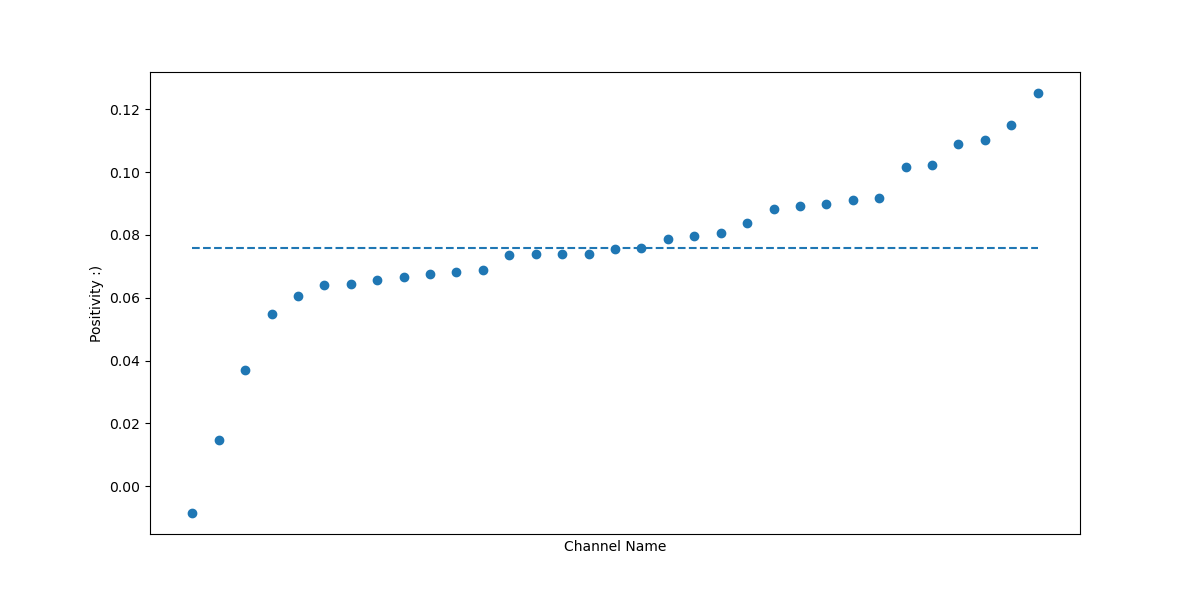

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
%matplotlib widget

x_name = "Channel Name"
y_name = "Positivity :)"
tooltip_name = "positivity value"

x= sctsdf['channelName']
y= sctsdf['scores']
tt = sctsdf['scores']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()


In [18]:
num_of_files = []
for channelId in LIST_OF_CHANNEL_IDS:
    num_of_files.append(len(os.listdir(channelId+"/txt/")))
 
cntvdf = pd.DataFrame.from_dict({'channelName':LIST_OF_CHANNEL_NAMES, 'number of transcripts collected': num_of_files, 'number of vids': LIST_OF_VIDEO_COUNT})

cntvdf

,channelName,number of transcripts collected,number of vids
0,Alex Clark,298,317
1,Alex Meyers,250,256
2,WowRightMeow,27,33
3,Andrei Terbea,112,136
4,Billy But Better,23,23
5,Casually Explained,80,81
6,CircleToonsHD,223,249
7,CurtRichy,89,97
8,CypherDen,58,63
9,Daidus,31,33


In [19]:
representation = sum(cntvdf['number of transcripts collected'])/sum(cntvdf['number of vids'])
print(representation)

0.8760815822002472


In [20]:
#https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
subsPerYearSinceFirstUpload = channelHolisticInfoDf['subscribersPerYearSinceFirstUpload']

In [21]:
zipped = zip(channelHolisticInfoDf.channelName, channelHolisticInfoDf.subscribersPerYearSinceFirstUpload)
sorted_channelName_to_rescaledSubs = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))
sctrs = pd.DataFrame.from_dict({'channelName': sorted_channelName_to_rescaledSubs.keys(), 'rescaledSubCount': sorted_channelName_to_rescaledSubs.values()})
sctrs

,channelName,rescaledSubCount
0,Ivan Animated,2.420918e+04
1,Billy But Better,5.466590e+04
2,CurtRichy,6.226363e+04
3,Zalinki,7.179712e+04
4,GetMadz,8.528998e+04
5,WowRightMeow,1.083499e+05
6,Young Yong Tales,1.312173e+05
7,Noodle,1.324890e+05
8,PantslessPajamas,1.397693e+05
9,CypherDen,2.047628e+05


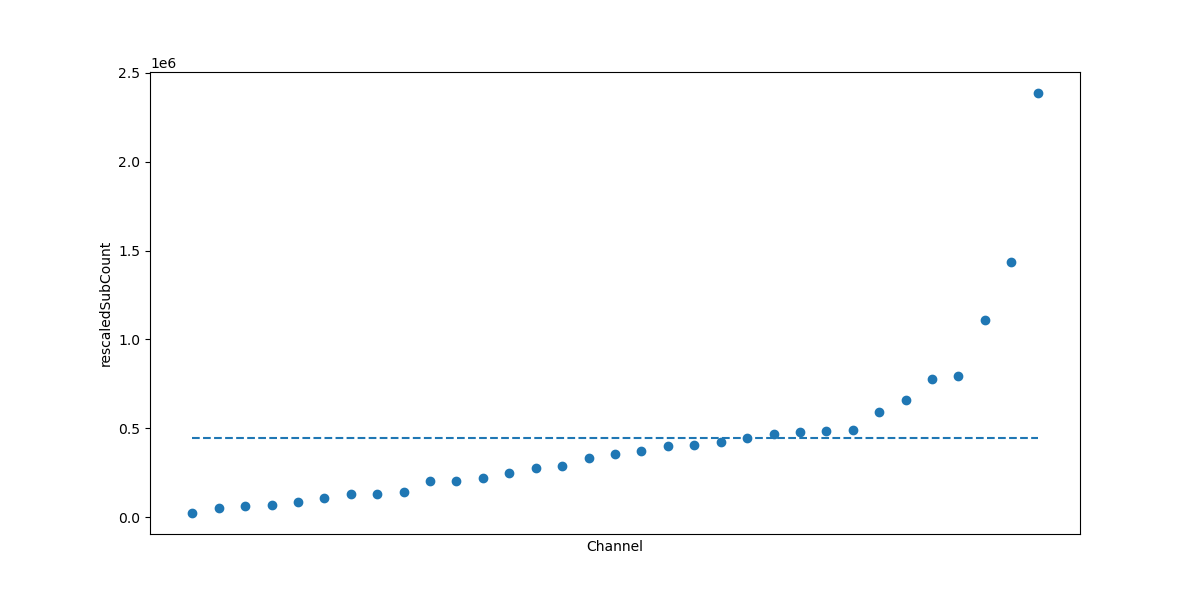

In [56]:
x_name = "Channel"
y_name = "rescaledSubCount"
tooltip_name = "subCountPerYearSinceFirstUpload"

x= sctrs['channelName']
y= sctrs['rescaledSubCount']
tt = sctrs['rescaledSubCount']

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(x, y)
avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
# Plot the average line
mean_x=np.arange(0,33,1)
mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

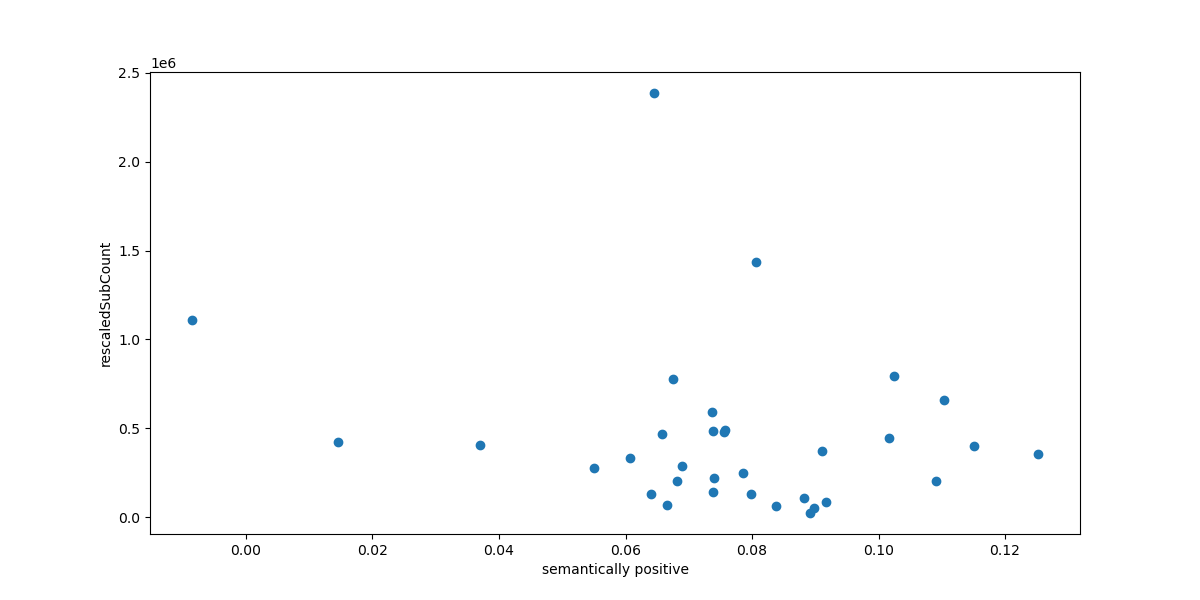

In [59]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
def generate_plot(semantic_df):
    x_name = "semantically positive"
    y_name = "rescaledSubCount"
    tooltip_name = "channelName"
    x= semantic_df['positivityScores']
    y= semantic_df['rescaledSubCount']
    tt = semantic_df[tooltip_name]
    fig, ax = plt.subplots(1, figsize=(12,6))
    sc = ax.scatter(x, y)

    avg_rescaledSubcount= sum(y)/len(LIST_OF_CHANNEL_NAMES)
    # Plot the average line
    mean_x=np.arange(0,33,1)
    mean_y=[avg_rescaledSubcount for i in np.zeros_like(x)]
    # mean_line = ax.plot(mean_x, mean_y, label='Mean', linestyle='--')

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(details):
        pos = sc.get_offsets()[details["channelName"]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(details["channelName"]), 
                            " ".join([details["positivityScores"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = sc.contains(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    cursor = mplcursors.cursor(sc, hover=True)
    cursor.connect(
    "add", lambda sel: sel.annotation.set_text(tt[sel.index]))
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
 generate_plot(semantic_df)

Pretty sure Oversimplified (and tbh, Odd1sOut) is messing up my calculations. 

In [76]:
semantic_df = pd.DataFrame.from_dict({'channelName': channelHolisticInfoDf['channelName'], 'rescaledSubCount': subsPerYearSinceFirstUpload, 'positivityScores': channelName_to_scores.values()})
semantic_df

,channelName,rescaledSubCount,positivityScores
0,Alex Clark,3.559353e+05,0.125169
1,Alex Meyers,4.474797e+05,0.101710
2,WowRightMeow,1.083499e+05,0.088169
3,Andrei Terbea,3.315021e+05,0.060723
4,Billy But Better,5.466590e+04,0.089793
5,Casually Explained,5.947656e+05,0.073624
6,CircleToonsHD,2.488131e+05,0.078586
7,CurtRichy,6.226363e+04,0.083848
8,CypherDen,2.047628e+05,0.068082
9,Daidus,2.907246e+05,0.068984


In [86]:
copy_without_oversimplified = semantic_df.drop('23')
copy_without_oversimplified_and_odd1sout = semantic_df.drop(['23', '24'])
semantic_df_copy_without_oversimplified = json.loads(json.dumps(copy_without_oversimplified.to_dict()))
semantic_df_copy_without_oversimplified_and_odd1sout = json.loads(json.dumps(copy_without_oversimplified_and_odd1sout.to_dict()))

